# Segundo Trabalho Prático IART

**Tema:** Exploring Mental Health Data

**Grupo:** A2_77 

**Membros de Grupo**: Francisco Afonso (up202208115), Miguel Caseira (up202207678), Pedro Santos (up202205900)
Miguel Caseira

## 📚 0. Bibliotecas 

Nesta secção, procedemos à instalação e importação das bibliotecas essenciais para o desenvolvimento do projeto. Cada uma desempenha um papel específico no projeto:

- **Pandas** – para a manipulação e análise de dados em estruturas tabulares.
- **NumPy** – para operações matemáticas e vetoriais eficientes.
- **Matplotlib / Seaborn** – para a criação de gráficos e visualizações estatísticas.
- **Scikit-learn** – para a implementação dos algoritmos de machine learning, avaliação de modelos e pré-processamento de dados.


In [1]:
# Instalar as dependências, se necessário
%pip install pandas numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report





## 📂 1. Carregamento dos Dados

In [4]:
df = pd.read_csv("data/train.csv")
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


## ✅ 2. Verificações Iniciais

Antes de avançar para a normalização e modelação, é fundamental garantir que o dataset não contém valores em falta, pois estes podem comprometer o desempenho dos modelos.

Nesta fase:
- Foram identificadas as colunas **numéricas** e **categóricas**, excluindo a variável alvo (`Depression`) das categóricas;
- Aplicou-se **imputação** de valores:
  - Para colunas numéricas, foi utilizada a mediana, uma escolha robusta face a outliers;
  - Para colunas categóricas, foi usado o valor mais frequente (moda);
- Após a imputação, confirmou-se que **não existem valores em falta** no dataset (`df.isnull().sum().sum() == 0`).

Esta preparação assegura que os modelos de machine learning possam ser treinados sem interrupções causadas por dados incompletos.

In [5]:
# Definir colunas
numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Depression']

# Imputação
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Verificar missing values
df.isnull().sum().sum()

np.int64(0)

## 🔍 3. Análise Exploratória de Dados (EDA)

Antes de avançar para o treino dos modelos, é fundamental realizar uma análise exploratória, com o objectivo de compreender a distribuição das variáveis, identificar padrões e detetar possíveis relações com a variável alvo (`Depression`).

Nesta fase, foram realizadas as seguintes análises:

- **Estrutura e estatísticas do dataset**: Verificou-se o tipo de cada coluna, valores nulos e estatísticas descritivas (média, desvio padrão, etc.);
- **Distribuição da variável alvo**: Verifica-se um desequilíbrio considerável entre as classes da variável `Depression`, com um número significativamente superior de exemplos da classe `0` (sem sintomas). Esta assimetria deve ser tida em conta na escolha dos modelos e das métricas de avaliação.
- **Distribuição por género e por cidade**: Permite observar a representatividade demográfica e geográfica da amostra;
- **Distribuição da idade**: Visualização da densidade e dispersão da variável `Age`;
- **Boxplots de variáveis numéricas vs. Depression**: Permitem comparar visualmente como variáveis como `CGPA`, `Financial Stress` ou `Work/Study Hours` variam entre os grupos com e sem sintomas de depressão;
- **Mapa de correlação entre variáveis numéricas**: Através de um heatmap, identificam-se relações lineares entre variáveis. Com base na correlação com a variável `Depression`, foram seleccionados apenas os atributos mais relevantes, descartando-se os que apresentavam uma correlação inferior a 0.05.

Esta análise constitui a base para a selecção de atributos e para a definição de estratégias de modelação mais adequadas.


Informação geral do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  object 
 7   Academic Pressure                      140700 non-null  float64
 8   Work Pressure                          140700 non-null  float64
 9   CGPA                                   140700 non-null  float64
 10  Study Satisfaction         

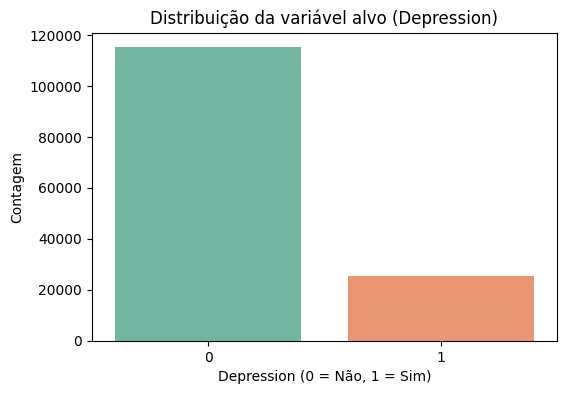

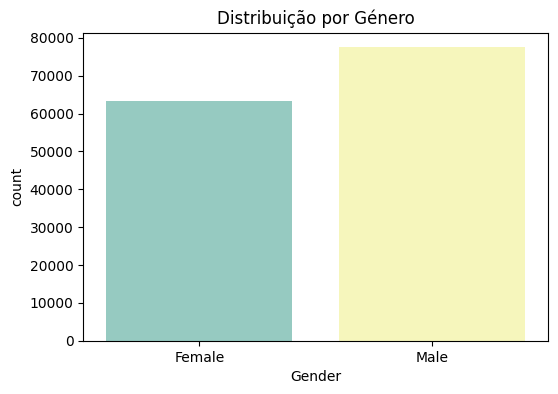

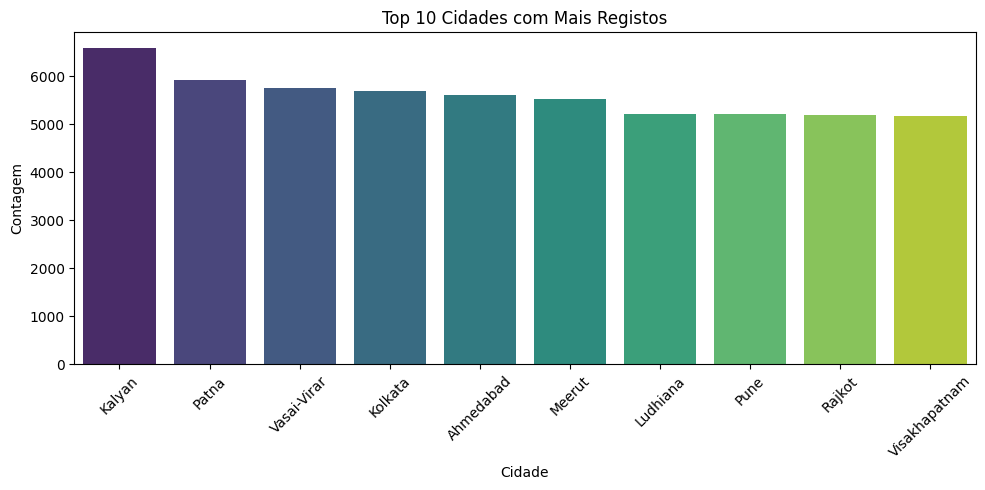

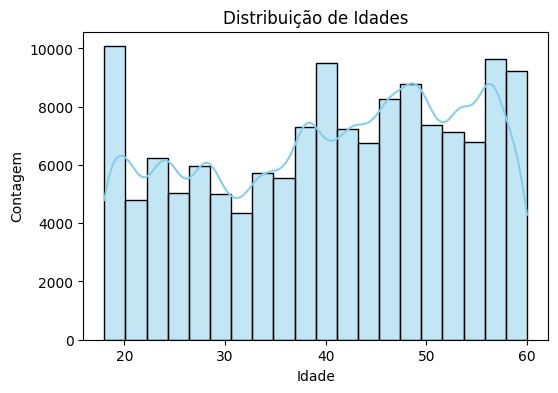

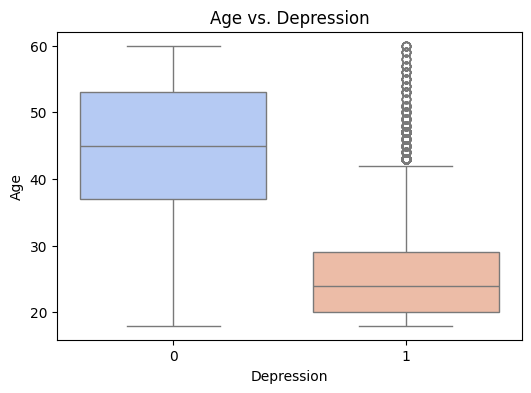

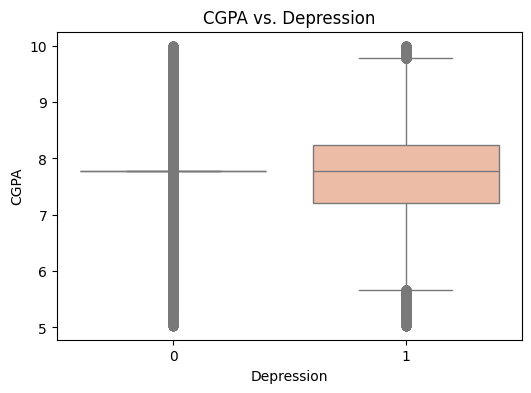

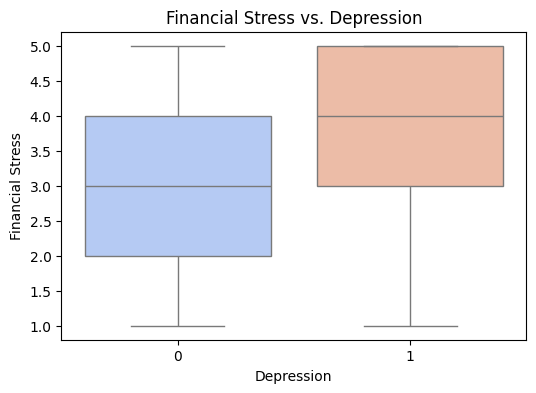

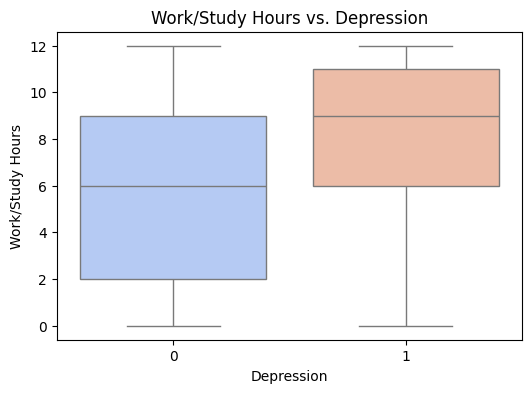

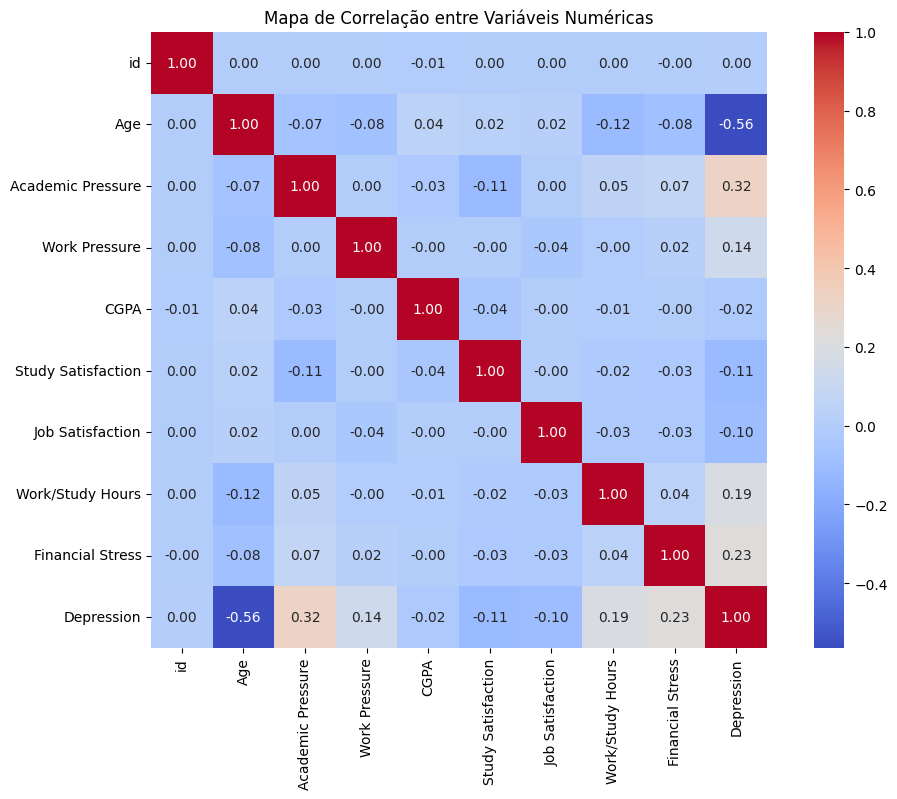


Correlação com a variável alvo (Depression):
Depression            1.000000
Age                   0.564671
Academic Pressure     0.316944
Financial Stress      0.227232
Work/Study Hours      0.191746
Work Pressure         0.137988
Study Satisfaction    0.114377
Job Satisfaction      0.103058
CGPA                  0.023050
id                    0.003944
Name: Depression, dtype: float64

Atributos com baixa correlação removidos: ['CGPA', 'id']


In [6]:
# Verificar estrutura do DataFrame
print("Informação geral do dataset:")
df.info()

# Sumário estatístico das colunas numéricas
print("\nSumário estatístico:")
print(df.describe())

# Verificar valores nulos
print("\nMissing values por coluna:")
print(df.isnull().sum())

# Distribuição da variável alvo (Depression)
plt.figure(figsize=(6, 4))
sns.countplot(x='Depression', data=df, palette='Set2', hue="Depression", legend=False)
plt.title("Distribuição da variável alvo (Depression)")
plt.xlabel("Depression (0 = Não, 1 = Sim)")
plt.ylabel("Contagem")
plt.show()

# Distribuição por género
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df, palette='Set3', hue="Gender", legend=False)
plt.title("Distribuição por Género")
plt.show()

# Top 10 cidades com mais entradas
plt.figure(figsize=(10, 5))
top_cities = df['City'].value_counts().nlargest(10)
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis', hue=top_cities.index, legend=False)
plt.title("Top 10 Cidades com Mais Registos")
plt.ylabel("Contagem")
plt.xlabel("Cidade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histograma das idades
plt.figure(figsize=(6, 4))
sns.histplot(df['Age'], kde=True, bins=20, color='skyblue')
plt.title("Distribuição de Idades")
plt.xlabel("Idade")
plt.ylabel("Contagem")
plt.show()

# Boxplots para algumas variáveis numéricas vs. Depression
numeric_to_plot = ['Age', 'CGPA', 'Financial Stress', 'Work/Study Hours']

for col in numeric_to_plot:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='Depression', y=col, data=df, palette='coolwarm', hue="Depression", legend=False)
        plt.title(f"{col} vs. Depression")
        plt.show()

# Heatmap de correlação (só variáveis numéricas)
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.show()

# Seleção de atributos altamente correlacionados com a variável alvo
cor_target = abs(corr["Depression"]).sort_values(ascending=False)
print("\nCorrelação com a variável alvo (Depression):")
print(cor_target)

# Podemos remover atributos com correlação muito baixa (< 0.05 por ex.)
low_corr_features = cor_target[cor_target < 0.05].index.tolist()
print("\nAtributos com baixa correlação removidos:", low_corr_features)

X = df.drop(columns=['id', 'Name', 'Depression'] + low_corr_features)


## ⚙️ 4. Pré-processamento dos Dados

Nesta etapa, o dataset é preparado para ser utilizado pelos algoritmos de aprendizagem. As transformações realizadas garantem que os dados estejam no formato adequado e que não existam valores em falta que possam comprometer o treino dos modelos.

As principais operações realizadas foram:

- **Separação das variáveis preditoras e da variável alvo** (`Depression`);
- **Remoção de colunas irrelevantes** como `id` e `Name`;
- **Imputação de valores em falta**:
  - Para variáveis numéricas, foi utilizada a mediana;
  - Para variáveis categóricas, foi utilizado o valor mais frequente (moda);
- **Codificação das variáveis categóricas** com `LabelEncoder`, convertendo respostas textuais como `"Yes"`/`"No"` em valores numéricos;
- **Normalização das variáveis numéricas** com `StandardScaler`, garantindo que todas as features têm média 0 e desvio padrão 1;
- **Divisão do dataset em treino e teste** com `train_test_split`, assegurando estratificação da variável alvo (`stratify=y`) para manter a proporção original de classes.

Este pré-processamento garante a integridade dos dados e permite o treino eficiente e justo dos modelos de machine learning.


In [7]:
categorical_cols = [
    'Gender', 'City', 'Working Professional or Student', 'Profession',
    'Sleep Duration', 'Dietary Habits', 'Degree',
    'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'
]

numeric_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

# Drop colunas irrelevantes
X = df.drop(columns=['id', 'Name', 'Depression'])
y = df['Depression']

# Imputação de missing values
num_imputer = SimpleImputer(strategy='median')
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Label Encoding das categóricas
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Normalização
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##  📈 5. Avaliação de Modelos

Após o treino dos modelos, é fundamental avaliar o seu desempenho de forma rigorosa, utilizando métricas apropriadas e visualizações que permitam uma análise comparativa clara.

Nesta etapa, foi definida uma função de avaliação comum para todos os classificadores, que executa os seguintes passos:

- **Treino e teste do modelo**, com medição do tempo necessário para cada fase;
- **Cálculo das principais métricas de classificação**, nomeadamente:
  - **Accuracy** – proporção de previsões corretas no total de amostras;
  - **Precision** – proporção de verdadeiros positivos entre as previsões positivas;
  - **Recall** – proporção de verdadeiros positivos identificados corretamente;
  - **F1 Score** – média harmónica entre precision e recall, especialmente útil em cenários de classes desbalanceadas;
- **Matriz de confusão**, que permite visualizar os acertos e erros do modelo de forma detalhada;
- **Curva ROC e valor AUC**, que ilustram a capacidade discriminativa do modelo entre classes, independentemente de thresholds.

Este processo é repetido para cada modelo treinado, assegurando uma avaliação consistente e comparável entre diferentes abordagens.

In [8]:
def avaliar_modelo(modelo, nome):
    start = time.time()
    modelo.fit(X_train, y_train)
    tempo_treino = time.time() - start

    start = time.time()
    y_pred = modelo.predict(X_test)
    tempo_teste = time.time() - start

    print(f"\n{nome}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print(f"Tempo Treino: {tempo_treino:.4f}s | Tempo Teste: {tempo_teste:.4f}s")

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()

    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:,1]
    else:
        y_proba = modelo.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)


## 🤖 6. Comparação entre Modelos de Classificação

Nesta secção, aplicamos a função de avaliação a diferentes algoritmos de aprendizagem supervisionada, com o objectivo de comparar o seu desempenho na tarefa de classificação da variável `Depression`.

Os modelos testados incluem:

- **Decision Tree** – modelo baseado em regras hierárquicas simples;
- **k-Nearest Neighbors (k-NN)** – classificador baseado na proximidade entre pontos no espaço de atributos;
- **Support Vector Machine (SVM)** – modelo que procura um hiperplano ótimo de separação entre classes;
- **Multilayer Perceptron (MLP)** – rede neuronal com uma ou mais camadas ocultas, capaz de capturar relações não-lineares.

Para cada modelo, analisamos as métricas de desempenho, o tempo de treino e teste, bem como a matriz de confusão e a curva ROC.

Esta comparação permite-nos identificar o modelo mais adequado ao problema, tendo em conta não apenas a precisão, mas também a robustez e a capacidade de generalização.



Decision Tree
Accuracy: 0.9009950248756219
Precision: 0.7246572697431937
Recall: 0.7340113436338744
F1 Score: 0.7293043140303148
Tempo Treino: 0.5140s | Tempo Teste: 0.0078s


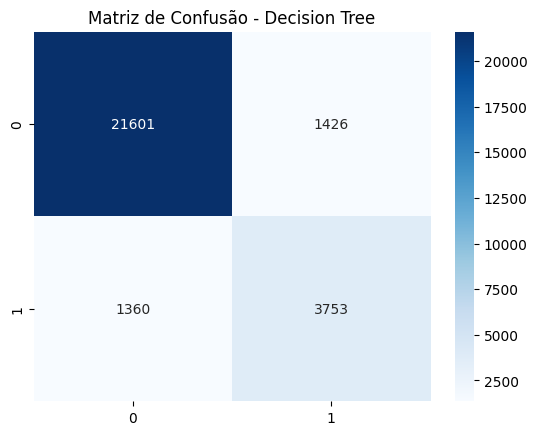

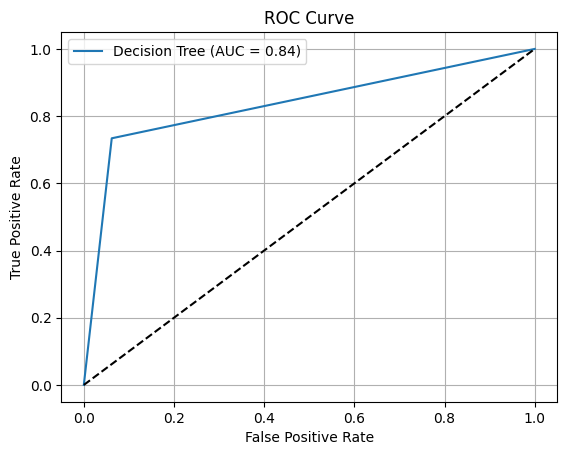


k-Nearest Neighbors
Accuracy: 0.8858564321250888
Precision: 0.7520551577830814
Recall: 0.5546645804811265
F1 Score: 0.6384511481314723
Tempo Treino: 0.0219s | Tempo Teste: 2.5674s


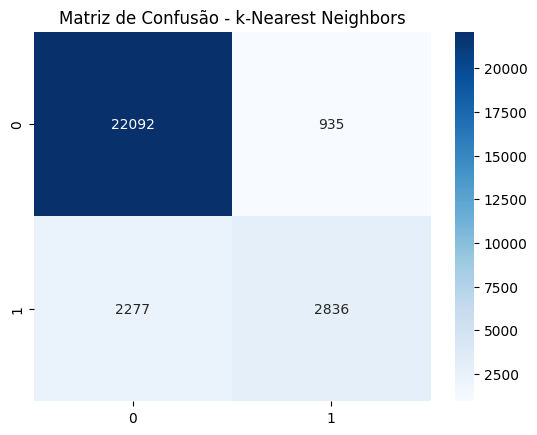

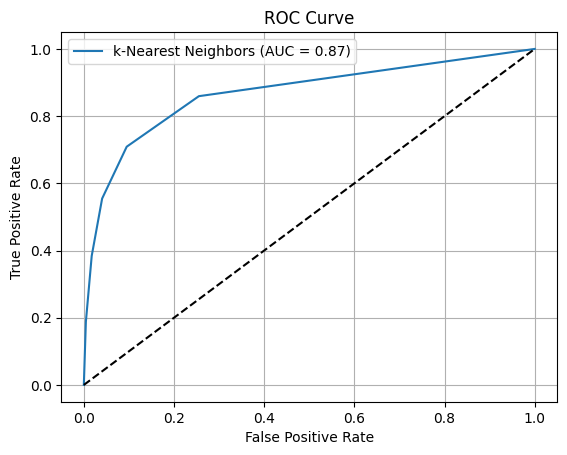


Multilayer Perceptron
Accuracy: 0.9368869936034115
Precision: 0.8370026257321753
Recall: 0.8104830823391356
F1 Score: 0.8235294117647058
Tempo Treino: 12.6457s | Tempo Teste: 0.0178s


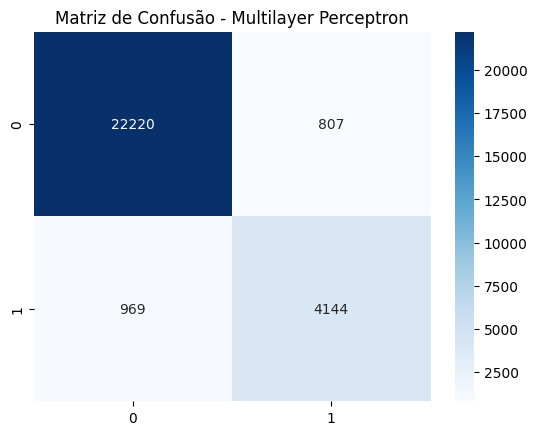

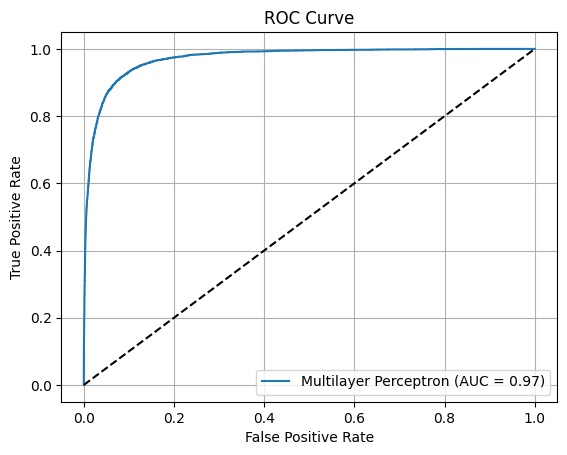

In [9]:
acc_f1_scores = {}

acc_f1_scores['Decision Tree'] = avaliar_modelo(DecisionTreeClassifier(random_state=42), "Decision Tree")
acc_f1_scores['k-NN'] = avaliar_modelo(KNeighborsClassifier(n_neighbors=5), "k-Nearest Neighbors")
#acc_f1_scores['SVM'] = avaliar_modelo(SVC(kernel='rbf', probability=True, random_state=42), "Support Vector Machine")
acc_f1_scores['Multilayer Perceptron'] = avaliar_modelo(MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42), "Multilayer Perceptron")

## 📊 7. Comparação Visual dos Resultados

Após a avaliação individual de cada modelo, foi construído um gráfico comparativo que sintetiza os principais indicadores de desempenho: **Accuracy** e **F1 Score**.

Este gráfico de barras permite uma visualização clara das diferenças entre os modelos, facilitando a identificação da abordagem mais equilibrada em termos de precisão e capacidade de lidar com o desbalanceamento da variável alvo.

Para além das barras, os valores numéricos foram colocados sobre cada coluna, reforçando a legibilidade dos resultados. A presença simultânea de ambas as métricas é importante: enquanto a **accuracy** mede o desempenho global, a **F1 score** dá-nos uma noção mais fiável em situações de desbalanceamento, como é o caso deste dataset.

Este resumo visual é fundamental para tomar decisões informadas sobre o modelo a utilizar na eventual aplicação a novos dados (ex: `test.csv`).


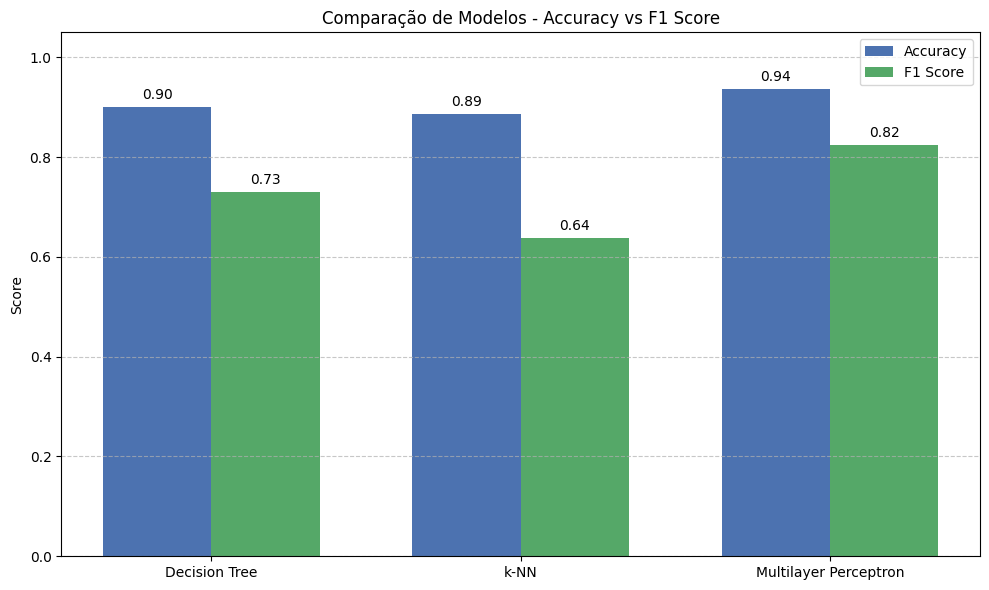

In [10]:
# Organizar resultados em DataFrame
resultados = pd.DataFrame(acc_f1_scores, index=['Accuracy', 'F1 Score']).T.reset_index()
resultados = resultados.rename(columns={'index': 'Modelo'})

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(resultados['Modelo']))

plt.bar(x - bar_width/2, resultados['Accuracy'], bar_width, label='Accuracy', color='#4c72b0')
plt.bar(x + bar_width/2, resultados['F1 Score'], bar_width, label='F1 Score', color='#55a868')

for i, val in enumerate(resultados['Accuracy']):
    plt.text(i - bar_width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

for i, val in enumerate(resultados['F1 Score']):
    plt.text(i + bar_width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

plt.xticks(x, resultados['Modelo'], rotation=0)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Comparação de Modelos - Accuracy vs F1 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 🔧 8. Ajuste de Hiperparâmetros (Parameter Tuning)

Após a avaliação inicial dos modelos, foi realizado um processo de afinação de hiperparâmetros (*parameter tuning*) com o objectivo de melhorar o desempenho dos modelos mais promissores.

Foram seleccionados dois modelos para afinação:

- **Decision Tree**, por ser um modelo simples e interpretável;
- **MLPClassifier (rede neuronal)**, que apresentou os melhores resultados na comparação anterior.

A afinação foi realizada com `GridSearchCV`, utilizando validação cruzada (`cv=3`) e como métrica principal o **F1 Score**, dado o desbalanceamento das classes.

Os melhores modelos encontrados foram posteriormente avaliados com a função `avaliar_modelo(...)`, para comparação directa com as versões iniciais.


### 🔧 Tuning do Decision Tree

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Melhores parâmetros (Decision Tree): {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}

Decision Tree (Tuned)
Accuracy: 0.9280383795309168
Precision: 0.8101647247890719
Recall: 0.7887737140621944
F1 Score: 0.7993261321970072
Tempo Treino: 0.3321s | Tempo Teste: 0.0037s


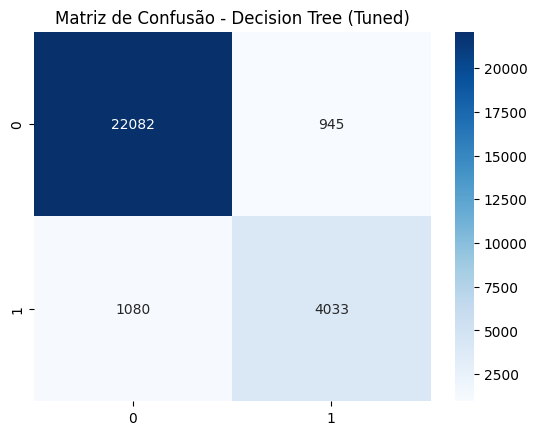

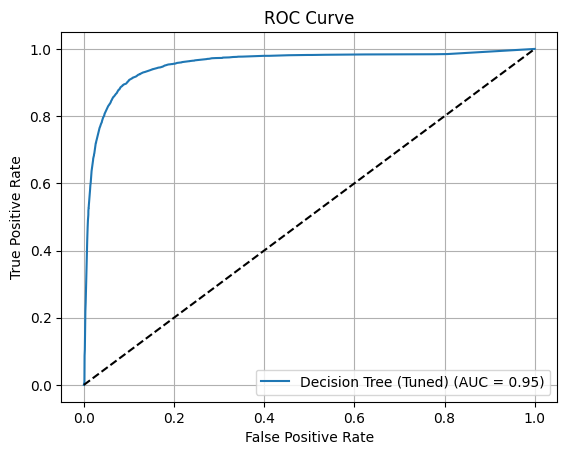

(0.9280383795309168, 0.7993261321970072)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid_tree = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                         param_grid_tree,
                         scoring='f1',
                         cv=3,
                         n_jobs=-1,
                         verbose=1)

grid_tree.fit(X_train, y_train)
best_tree = grid_tree.best_estimator_

print("Melhores parâmetros (Decision Tree):", grid_tree.best_params_)
avaliar_modelo(best_tree, "Decision Tree (Tuned)")


### 🔧 Tuning do MLPClassifier

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Melhores parâmetros (MLPClassifier): {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

MLPClassifier (Tuned)
Accuracy: 0.9359275053304904
Precision: 0.8272044286279162
Recall: 0.8183062781146098
F1 Score: 0.8227312948579294
Tempo Treino: 20.3962s | Tempo Teste: 0.0478s


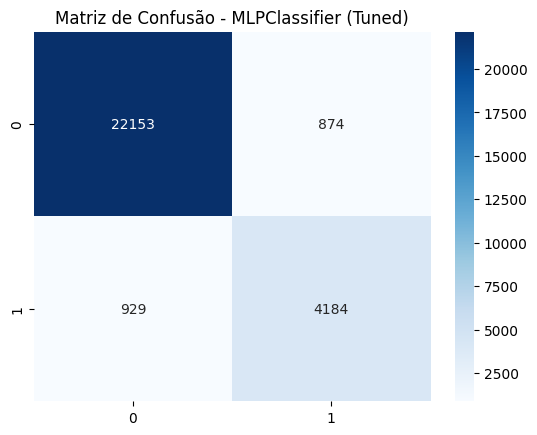

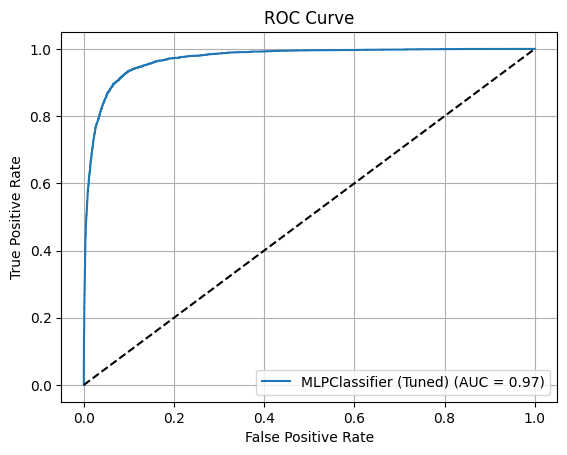

(0.9359275053304904, 0.8227312948579294)

In [12]:
from sklearn.neural_network import MLPClassifier

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

grid_mlp = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42),
                        param_grid_mlp,
                        scoring='f1',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_

print("Melhores parâmetros (MLPClassifier):", grid_mlp.best_params_)
avaliar_modelo(best_mlp, "MLPClassifier (Tuned)")


## 📊 9. Comparação Visual Após o Ajuste de Hiperparâmetros

Depois da afinação dos hiperparâmetros dos modelos `Decision Tree` e `MLPClassifier`, procedeu-se à sua reavaliação com os mesmos dados de teste.

Nesta secção, comparamos os resultados obtidos antes e depois do tuning, através de um gráfico de barras que mostra as métricas **Accuracy** e **F1 Score** para cada modelo.

Este tipo de análise permite verificar se o ajuste de hiperparâmetros teve impacto significativo no desempenho dos modelos, especialmente na sua capacidade de generalização.

A conclusão tirada foi que o modelo Decision Tree obteve resultados bastante superiores, com um aumento do F1 Score de 0.73 para 0.82 e que o MLP teve resultados muito semelhantes aos obtidos antes do tuning.

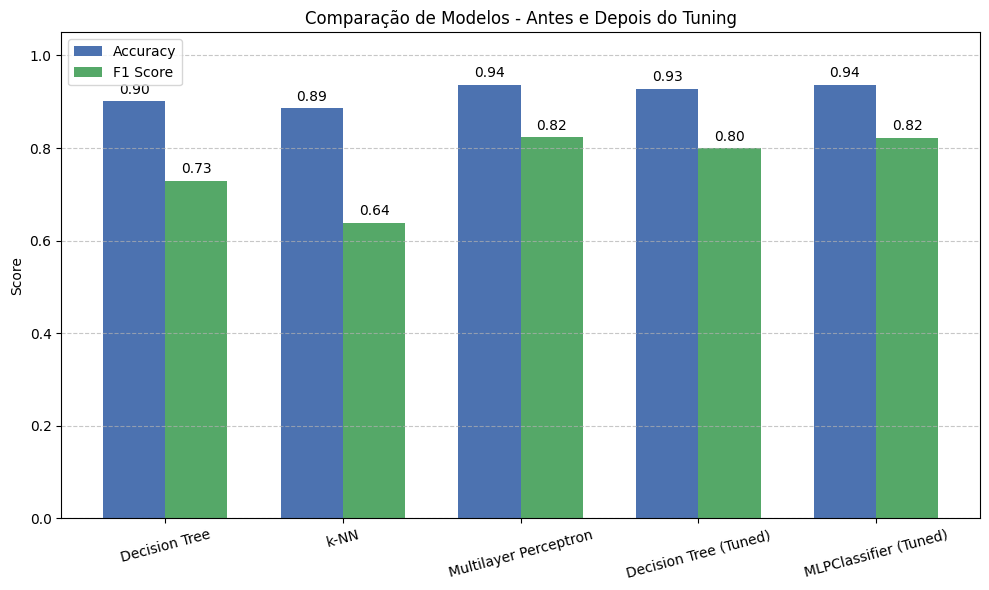

In [13]:
# Avaliar os modelos afinados
modelos_afinados = {
    "Decision Tree (Tuned)": best_tree,
    "MLPClassifier (Tuned)": best_mlp
}

afinados_scores = []

for nome, modelo in modelos_afinados.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    afinados_scores.append([nome, acc, f1])

# Combinar com os resultados anteriores (opcional: refaz tabela anterior com nomes fixos)
df_afinados = pd.DataFrame(afinados_scores, columns=['Modelo', 'Accuracy', 'F1 Score'])

# Juntar ao DataFrame anterior se ainda o tiveres (por exemplo, `resultados`)
df_completo = pd.concat([resultados, df_afinados], ignore_index=True)

# Gráfico atualizado
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(df_completo['Modelo']))

plt.bar(x - bar_width/2, df_completo['Accuracy'], bar_width, label='Accuracy', color='#4c72b0')
plt.bar(x + bar_width/2, df_completo['F1 Score'], bar_width, label='F1 Score', color='#55a868')

for i, val in enumerate(df_completo['Accuracy']):
    plt.text(i - bar_width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

for i, val in enumerate(df_completo['F1 Score']):
    plt.text(i + bar_width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

plt.xticks(x, df_completo['Modelo'], rotation=15)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Comparação de Modelos - Antes e Depois do Tuning")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 📚 10. Curva de Aprendizagem do Melhor Modelo

A curva de aprendizagem mostra a evolução da accuracy no treino e na validação à medida que aumentamos o número de exemplos usados no treino do modelo `MLPClassifier`.

Observa-se que:
- A performance no treino permanece estável e elevada, com uma ligeira diminuição natural devido ao aumento da complexidade dos dados;
- A performance na validação melhora gradualmente com o aumento da amostra, aproximando-se da do treino, o que indica uma boa capacidade de generalização;
- A diferença entre as duas curvas é pequena, o que sugere que **não há overfitting relevante**;
- O modelo poderá beneficiar ligeiramente de mais dados, mas já apresenta **estabilidade e boa performance** com o volume atual.

Esta análise confirma que o MLP é um modelo robusto e adequado para o problema


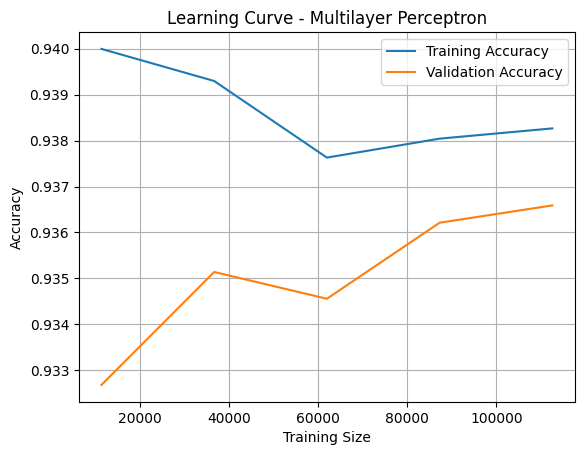

In [13]:
melhor_modelo = MLPClassifier(random_state=42)
train_sizes, train_scores, val_scores = learning_curve(melhor_modelo, X, y, cv=5, scoring='accuracy')

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Multilayer Perceptron")
plt.legend()
plt.grid()
plt.show()

## ❌ 11. Erro de Treino vs. Erro de Validação

Neste gráfico analisamos a evolução do erro (1 - accuracy) tanto no conjunto de treino como no de validação, em função da quantidade de dados utilizados no treino do modelo `MLPClassifier`.

Observações principais:

- O **erro de treino** mantém-se bastante baixo (~0.060), com uma ligeira oscilação à medida que o número de exemplos aumenta;
- O **erro de validação** é também relativamente baixo e aproxima-se do erro de treino com o aumento da amostra;
- A **diferença entre os dois erros é pequena**, o que indica que o modelo apresenta uma **boa capacidade de generalização**, sem sinais significativos de overfitting.

Esta análise confirma que o modelo está a aprender de forma eficaz e robusta, tirando partido da quantidade de dados disponível e mantendo um desempenho consistente em novos exemplos.


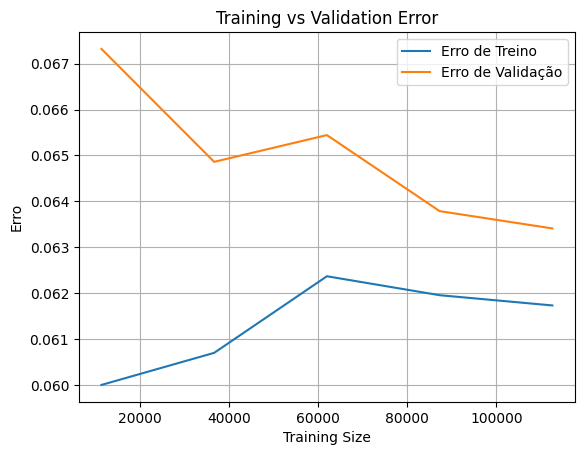

In [14]:
train_errors = 1 - train_mean
val_errors = 1 - val_mean

plt.plot(train_sizes, train_errors, label="Erro de Treino")
plt.plot(train_sizes, val_errors, label="Erro de Validação")
plt.xlabel("Training Size")
plt.ylabel("Erro")
plt.title("Training vs Validation Error")
plt.legend()
plt.grid()
plt.show()


## 📄 12. Relatórios de Classificação por Modelo

Para além da comparação global com métricas agregadas como Accuracy e F1 Score, é importante analisar o desempenho de cada modelo por classe. O `classification_report` do `scikit-learn` permite avaliar:

- **Precision**: proporção de previsões corretas entre os casos identificados como positivos;
- **Recall**: proporção de positivos corretamente identificados pelo modelo (muito relevante neste contexto);
- **F1 Score**: média harmónica entre precision e recall, útil quando há desbalanceamento de classes;
- **Support**: número de exemplos reais em cada classe.

Estes relatórios foram gerados para os quatro modelos analisados:

- Decision Tree  
- k-Nearest Neighbors (k-NN)  
- Support Vector Machine (SVM)  
- Multilayer Perceptron (MLP)

Esta análise detalhada permite perceber, por exemplo, se um modelo tem boa precisão mas falha muitos casos positivos (baixo recall), o que seria preocupante num cenário de identificação de sintomas de depressão.


In [ ]:
for nome_modelo, modelo in zip(resultados.index, [DecisionTreeClassifier(), KNeighborsClassifier(), MLPClassifier(max_iter=1000)]):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f"\nRelatório de Classificação - {nome_modelo}")
    print(classification_report(y_test, y_pred))




Relatório de Classificação - 0
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     23027
           1       0.72      0.74      0.73      5113

    accuracy                           0.90     28140
   macro avg       0.83      0.84      0.84     28140
weighted avg       0.90      0.90      0.90     28140


Relatório de Classificação - 1
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23027
           1       0.75      0.55      0.64      5113

    accuracy                           0.89     28140
   macro avg       0.83      0.76      0.79     28140
weighted avg       0.88      0.89      0.88     28140

